# 1. MODELO DE OTIMIZAÇÃO

## 1.1 Bibliotecas

In [1]:
from gurobipy import *
import gurobipy as gp
from gurobipy import GRB
import random
from random import sample
import itertools
import pandas as pd
import numpy as np
import re
from tabulate import tabulate
from pulp import LpVariable, LpProblem, LpMinimize
import pulp as lp
import math
import re
import time

import pyomo.environ as pyo
from   pyomo.opt import SolverFactory

from epanettools import epanet2 as et
import wntr
import wntr.network.controls as controls
import networkx as nx
import plotly as py                                   
import plotly.express as px                         
import plotly.graph_objects as go                   
#import matplotlib.pyplot as plt        # descomentar se der problema nos gráficos     
# %matplotlib inline

from datetime import datetime, timedelta 

## 1.2 Dados de entrada

In [2]:
# Antes de inciar conferir no arquivo

# Remover controles e padrões da bomba
# Colocar em uma linhas os custos das bombas
# Colocar em uma linha o padrão de consumo

### 1.2.1 Dados do inp

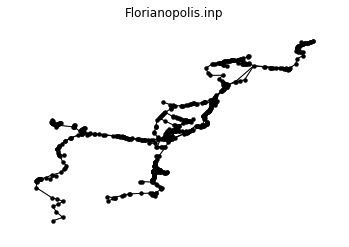

<AxesSubplot:title={'center':'Florianopolis.inp'}>

In [3]:
# Acessando inp

# Rede de Florianópolis de Vieira 2020
nome_arquivo = 'Florianopolis.inp' # .inp em metros cúbicos/hora

wn = wntr.network.WaterNetworkModel(nome_arquivo)

# Desenho da rede
wntr.graphics.plot_network(wn, title=wn.name)

In [4]:
# Duração total do período de simulação
# Florianópolis a simulação inicia 0h
T = range(1, 25)
print("Períodos =", list(T))
    
# Número de horas em cada período (1h)
Nh = (wn.options.time.pattern_timestep) / 3600 
print("Números de horas de cada período =", Nh) 

Períodos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
Números de horas de cada período = 1.0


In [5]:
# NÓS

# Nós
N = wn.node_name_list  
print("N =", N) 

# Nós que são fontes
F = wn.reservoir_name_list                                         
print("F =", F) 

# Nós que são reservátorios
R = wn.tank_name_list 
print("R =", R) 

# Nós que são junções
J = []
for node, no in wn.nodes():
        if no.name not in F:
            if no.name not in R:
                J.append(no.name)
print("J =", J)

N = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '45', '46', '47', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '162', '164', '166'

In [6]:
# ARCOS

# Arcos
#A = []
#for link_name in wn.link_name_list:
#    link = wn.get_link(link_name)
#    node1 = wn.get_node(link.start_node).name
#    node2 = wn.get_node(link.end_node).name
#    A.append((node1, node2))
#print("A =", A)

# Arcos que possuem bombas
B = []
for link, arco in wn.links():
    if arco.name in wn.pump_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        B.append((node1, node2))
print("B =", B)

# Arcos que possuem válvulas
V = []
for link, arco in wn.links():
    if arco.name in wn.valve_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        V.append((node1, node2))
print("V =", V)

# Arcos que atuam por gravidade (sem bombas e sem válvulas)
G = []
for link, arco in wn.links():
    if arco.name not in wn.pump_name_list and arco.name not in wn.valve_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        G.append((node1, node2))
        G.append((node2, node1)) #bidirecionais  
print("G =", G)

# Criar o conjunto A como a união de G, B e V
A = set(B) | set(V) | set(G)
A = list(A)
print("A =", A)

B = [('42', '41'), ('177', '180'), ('682', '683'), ('685', '686'), ('454', '455'), ('44', '43'), ('478', '180')]
V = []
G = [('1', '2'), ('2', '1'), ('2', '3'), ('3', '2'), ('3', '4'), ('4', '3'), ('4', '5'), ('5', '4'), ('5', '6'), ('6', '5'), ('6', '7'), ('7', '6'), ('7', '8'), ('8', '7'), ('8', '9'), ('9', '8'), ('9', '10'), ('10', '9'), ('10', '11'), ('11', '10'), ('11', '12'), ('12', '11'), ('12', '13'), ('13', '12'), ('13', '14'), ('14', '13'), ('14', '15'), ('15', '14'), ('15', '16'), ('16', '15'), ('16', '17'), ('17', '16'), ('17', '18'), ('18', '17'), ('18', '19'), ('19', '18'), ('19', '20'), ('20', '19'), ('20', '21'), ('21', '20'), ('21', '22'), ('22', '21'), ('22', '23'), ('23', '22'), ('23', '24'), ('24', '23'), ('24', '25'), ('25', '24'), ('25', '26'), ('26', '25'), ('26', '27'), ('27', '26'), ('27', '28'), ('28', '27'), ('28', '29'), ('29', '28'), ('29', '30'), ('30', '29'), ('30', '31'), ('31', '30'), ('31', '32'), ('32', '31'), ('32', '33'), ('33', '32'), ('33', '34'),

In [7]:
# NÓ INICIAL E FINAL DE CADA ARCO

arcos = []
nos_iniciais = []
nos_finais = []

# Iterar sobre todos os arcos na rede
for link_name, link in wn.links():
    arcos.append(link_name)
    nos_iniciais.append(link.start_node)
    nos_finais.append(link.end_node)

data = {'Arco': arcos, 'Nó Inicial': nos_iniciais, 'Nó Final': nos_finais}
df = pd.DataFrame(data)
print(df)

    Arco Nó Inicial Nó Final
0      1          1        2
1      2          2        3
2      3          3        4
3      4          4        5
4      5          5        6
..   ...        ...      ...
650   B3        682      683
651   B4        685      686
652   B5        454      455
653   B6         44       43
654  B2b        478      180

[655 rows x 3 columns]


In [8]:
# NÓS PREDECESSORES E SUCESSORES

# Criar um grafo direcionado a partir da rede EPANET
Graf = wn.get_graph()
# Adicionar arcos bidirecionais de G ao grafo
for (node1, node2) in G:
    Graf.add_edge(node1, node2)

# Nós predecessores
predecessors = {}
for node in Graf.nodes():
    P = [pred for pred in Graf.predecessors(node)]
    predecessors[node] = P
for node, P in predecessors.items():
    print(f"Nó: {node}, Predecessores: {P}")

# Nós sucessores
successors = {}
for node in Graf.nodes():
    S = [succ for succ in Graf.successors(node)]
    successors[node] = S
for node, S in successors.items():
    print(f"Nó: {node}, Sucessores: {S}")

Nó: 1, Predecessores: ['2', '524', '525']
Nó: 2, Predecessores: ['1', '3']
Nó: 3, Predecessores: ['2', '4']
Nó: 4, Predecessores: ['3', '5']
Nó: 5, Predecessores: ['4', '6']
Nó: 6, Predecessores: ['5', '7']
Nó: 7, Predecessores: ['6', '8']
Nó: 8, Predecessores: ['7', '9']
Nó: 9, Predecessores: ['8', '10', '528']
Nó: 10, Predecessores: ['9', '11']
Nó: 11, Predecessores: ['10', '12']
Nó: 12, Predecessores: ['11', '13']
Nó: 13, Predecessores: ['12', '14']
Nó: 14, Predecessores: ['13', '15']
Nó: 15, Predecessores: ['14', '16']
Nó: 16, Predecessores: ['15', '17']
Nó: 17, Predecessores: ['16', '18', '533', '536']
Nó: 18, Predecessores: ['17', '19']
Nó: 19, Predecessores: ['18', '20']
Nó: 20, Predecessores: ['19', '21']
Nó: 21, Predecessores: ['20', '22']
Nó: 22, Predecessores: ['21', '23']
Nó: 23, Predecessores: ['22', '24']
Nó: 24, Predecessores: ['23', '25']
Nó: 25, Predecessores: ['24', '26']
Nó: 26, Predecessores: ['25', '27']
Nó: 27, Predecessores: ['26', '28']
Nó: 28, Predecessores: ['

C:\Users\lemiq\AppData\Local\Temp/ipykernel_12896/729179350.py:4: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  Graf = wn.get_graph()


In [9]:
# CUSTO DE FUNCIONAMENTO DAS BOMBAS

# Lê tarifas
def read_pump_tariffs(nome_arquivo):
    tarifa = {}
    in_patterns_block = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_patterns_block:
                if line.startswith('Azul'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("Azul", []).extend(float(match) for match in matches) 
                if line.startswith('Verde'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("Verde", []).extend(float(match) for match in matches)
                if line.startswith('Convencional'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("Convencional", []).extend(float(match) for match in matches) 
                if line.startswith('Monomio'): 
                    matches = re.findall(r'\b\d+\.\d+\b', line)
                    if matches:
                        tarifa.setdefault("Monomio", []).extend(float(match) for match in matches) 
            elif line == '[PATTERNS]':
                in_patterns_block = True
    return tarifa
tarifa = read_pump_tariffs(nome_arquivo)
df = pd.DataFrame(tarifa)
#print(df)

c = {}

# Iterar sobre cada arco de B
node1 = {}
node2 = {}

for node1, node2 in B: #B1
    arco = ('42', '41')  
    for t, custo in enumerate(tarifa.get("Azul", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #B2
    arco = ('177', '180')  
    for t, custo in enumerate(tarifa.get("Verde", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #B2b
    arco = ('478', '180')  
    for t, custo in enumerate(tarifa.get("Verde", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #B3
    arco = ('682', '683')  
    for t, custo in enumerate(tarifa.get("Convencional", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #B4
    arco = ('685', '686')  
    for t, custo in enumerate(tarifa.get("Monomio", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #B5
    arco = ('454', '455')  
    for t, custo in enumerate(tarifa.get("Monomio", []), start=1): 
        c[(arco, t)] = custo
        
for node1, node2 in B: #B6
    arco = ('44', '43')  
    for t, custo in enumerate(tarifa.get("Convencional", []), start=1): 
        c[(arco, t)] = custo

print("Custos por arco e período:", c)

Custos por arco e período: {(('42', '41'), 1): 0.226484133794058, (('42', '41'), 2): 0.226484133794058, (('42', '41'), 3): 0.226484133794058, (('42', '41'), 4): 0.226484133794058, (('42', '41'), 5): 0.226484133794058, (('42', '41'), 6): 0.226484133794058, (('42', '41'), 7): 0.226484133794058, (('42', '41'), 8): 0.226484133794058, (('42', '41'), 9): 0.226484133794058, (('42', '41'), 10): 0.226484133794058, (('42', '41'), 11): 0.226484133794058, (('42', '41'), 12): 0.226484133794058, (('42', '41'), 13): 0.226484133794058, (('42', '41'), 14): 0.226484133794058, (('42', '41'), 15): 0.226484133794058, (('42', '41'), 16): 0.226484133794058, (('42', '41'), 17): 0.226484133794058, (('42', '41'), 18): 0.33767472525097, (('42', '41'), 19): 0.33767472525097, (('42', '41'), 20): 0.33767472525097, (('42', '41'), 21): 0.226484133794058, (('42', '41'), 22): 0.226484133794058, (('42', '41'), 23): 0.226484133794058, (('42', '41'), 24): 0.226484133794058, (('177', '180'), 1): 0.285692579303081, (('177',

In [10]:
# DEMANDA POR PERÍODO
# Florianópolis já é em m3/segundo

# Encontra os nós com demanda positiva
def find_nodes_with_demand(nome_arquivo):
    nodes_with_demand = {}
    in_junctions_section = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_junctions_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    node_id = parts[0]
                    demand = float(parts[2])
                    if demand > 0:
                        pattern = parts[3] if len(parts) > 3 else "None"
                        nodes_with_demand[node_id] = {'demand': demand, 'pattern': pattern}
            elif line == '[JUNCTIONS]':
                in_junctions_section = True
    return nodes_with_demand

# Lê o padrão da demanda
def read_demand_patterns(nome_arquivo):
    demand_patterns = {}
    in_patterns_section = False
    current_pattern = None  
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_patterns_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    pattern_id = parts[0]
                    if pattern_id == "consumo":
                        pattern_values = [float(val) for val in parts[1:]]
                        # Preencher os valores do padrão até 24 horas
                        while len(pattern_values) < 24:
                            pattern_values.extend(pattern_values)
                        demand_patterns[pattern_id] = pattern_values[:24]
                        print("Padrão:", pattern_id)
                        print("Valores do padrão:", pattern_values[:24])
                        break  # Encerra o loop após encontrar o padrão correto
            elif line == '[PATTERNS]':
                in_patterns_section = True            
    return demand_patterns

# Calcula a demanda a cada período através do padrão
def calculate_demand_per_period(nodes_with_demand, demand_patterns):
    demand_per_period = {}
    for node, data in nodes_with_demand.items():
        pattern = data['pattern']
        demand = data['demand']
        pattern_values = demand_patterns.get(pattern)
        if pattern_values:
            # Repetir os valores do padrão para 24 horas
            repeated_pattern_values = pattern_values * (24 // len(pattern_values))
            demand_per_period[node] = [demand * value for value in repeated_pattern_values]
        else:
            # Caso não haja padrão, preenche com a demanda constante
            demand_per_period[node] = demand * 24
    return demand_per_period

nodes_with_demand = find_nodes_with_demand(nome_arquivo)
demand_patterns = read_demand_patterns(nome_arquivo)
demand_per_period = calculate_demand_per_period(nodes_with_demand, demand_patterns)
    
d = {'Nó': [], 'Período': [], 'Demanda': []}
for node, demand_values in demand_per_period.items():
    for periodo, valor in enumerate(demand_values, start=1):
        d['Nó'].append(node)
        d['Período'].append(periodo)
        d['Demanda'].append(valor)

df = pd.DataFrame(d)
#print(df.to_string(index=False))

demand_dict = {(row['Nó'], row['Período']): row['Demanda'] for index, row in df.iterrows()}

print("\nDicionário demand_dict:")
for key, value in demand_dict.items():
    print(f"{key}: {value}")

Padrão: consumo
Valores do padrão: [0.65, 0.52, 0.52, 0.52, 0.61, 0.72, 0.73, 0.8, 0.94, 1.08, 1.15, 1.18, 1.08, 0.73, 0.83, 0.8, 1.34, 1.4, 1.51, 1.64, 1.64, 1.58, 1.3, 0.73]

Dicionário demand_dict:
('1', 1): 1.0205000000000002
('1', 2): 0.8164
('1', 3): 0.8164
('1', 4): 0.8164
('1', 5): 0.9577
('1', 6): 1.1304
('1', 7): 1.1461000000000001
('1', 8): 1.2560000000000002
('1', 9): 1.4758
('1', 10): 1.6956000000000002
('1', 11): 1.8054999999999999
('1', 12): 1.8526
('1', 13): 1.6956000000000002
('1', 14): 1.1461000000000001
('1', 15): 1.3031
('1', 16): 1.2560000000000002
('1', 17): 2.1038
('1', 18): 2.198
('1', 19): 2.3707000000000003
('1', 20): 2.5747999999999998
('1', 21): 2.5747999999999998
('1', 22): 2.4806000000000004
('1', 23): 2.0410000000000004
('1', 24): 1.1461000000000001
('2', 1): 1.4885000000000002
('2', 2): 1.1908
('2', 3): 1.1908
('2', 4): 1.1908
('2', 5): 1.3969
('2', 6): 1.6488
('2', 7): 1.6717
('2', 8): 1.832
('2', 9): 2.1526
('2', 10): 2.4732000000000003
('2', 11): 2.63

In [11]:
# VOLUMES MAX, MIN E INICIAL DOS RESERVATÓRIOS
# já estão em metros cúbicos, pois no .inp os valores para o diâmetro do reservatório e a altura estão em metros

def find_tanks(nome_arquivo):
    tanks = {}
    H_0 = {}  
    H_min = {}  
    H_max = {}  
    in_tanks_section = False
    with open(nome_arquivo, 'r') as f:
        for line in f:
            line = line.strip()
            if in_tanks_section:
                if line.startswith('['):
                    break
                elif line and not line.startswith(';'):
                    parts = line.split()
                    tank_id = parts[0]
                    elevation = float(parts[1])
                    min_level = float(parts[3])
                    max_level = float(parts[4])
                    diameter = float(parts[5])
                    initial_level = float(parts[2])
                    # Volume do cilindro
                    initial_volume = ((initial_level - min_level) / (max_level - min_level)) * ((3.14159 * diameter**2) / 4)
                    tanks[tank_id] = {'elevation': elevation, 'min_level': min_level, 'max_level': max_level, 'diameter': diameter}
                    H_0[tank_id] = initial_volume
                    #H_min[tank_id] = ((min_level - min_level) / (max_level - min_level)) * ((3.14159 * diameter**2) / 4)  
                    H_max[tank_id] = ((max_level - min_level) / (max_level - min_level)) * ((3.14159 * diameter**2) / 4)
                    H_min[tank_id] = 0.25 * H_max[tank_id]
            elif line == '[TANKS]':
                in_tanks_section = True
    return tanks, H_0, H_min, H_max

tanks, H_0, H_min, H_max = find_tanks(nome_arquivo)

for tank_id, initial_volume in H_0.items():
    print(f"ID: {tank_id}, Volume Inicial: {H_0[tank_id]}, Volume Mínimo: {H_min[tank_id]}, Volume Máximo: {H_max[tank_id]}")

ID: 48, Volume Inicial: 631.4259301071428, Volume Mínimo: 298.64739937499996, Volume Máximo: 1194.5895974999999
ID: 61, Volume Inicial: 51.42208367828573, Volume Mínimo: 83.32282077500001, Volume Máximo: 333.29128310000004
ID: 74, Volume Inicial: 0.0, Volume Mínimo: 122.71835937499999, Volume Máximo: 490.87343749999997
ID: 355, Volume Inicial: 212.65683084979196, Volume Mínimo: 99.93272126399998, Volume Máximo: 399.7308850559999
ID: 431, Volume Inicial: 65.99918972730914, Volume Mínimo: 49.99938615705239, Volume Máximo: 199.99754462820957


In [12]:
# VAZÃO MÁXIMA - bombas e tubulação
# rendimento da bomba em 80%
# já está em metros cúbicos por hora

v = {}

for link_name in wn.link_name_list: 
    link = wn.get_link(link_name) 
    # Link sem bomba 
    if isinstance(link, wntr.network.elements.Pipe): 
        diametro = link.diameter 
        vazao = (math.pi * (diametro ** 2) * 3600 * 3) / 4 # Calcula a vazão 
        no_inicial = wn.get_node(link.start_node).name 
        no_final = wn.get_node(link.end_node).name 
        v[(no_inicial, no_final)] = vazao
        v[(no_final, no_inicial)] = vazao  # Adiciona o arco bidirecional

    # Link com bomba
    # Vazão com rendimento da bomba em 80%
    v[('42', '41')] = 840  #B1
    v[('177', '180')] = 118  #B2
    v[('478', '180')] = 118  #B2b
    v[('682', '683')] = 504  #B3
    v[('685', '686')] = 160 #B4
    v[('454', '455')] = 172 #B5
    v[('44', '43')] = 80 #B6
    
for (no_inicial, no_final), vazao in v.items(): 
    print(f"Link: ({no_inicial}, {no_final}), Vazão: {vazao:.2f} metros cúbicos por hora.")

Link: (1, 2), Vazão: 190.85 metros cúbicos por hora.
Link: (2, 1), Vazão: 190.85 metros cúbicos por hora.
Link: (42, 41), Vazão: 840.00 metros cúbicos por hora.
Link: (177, 180), Vazão: 118.00 metros cúbicos por hora.
Link: (478, 180), Vazão: 118.00 metros cúbicos por hora.
Link: (682, 683), Vazão: 504.00 metros cúbicos por hora.
Link: (685, 686), Vazão: 160.00 metros cúbicos por hora.
Link: (454, 455), Vazão: 172.00 metros cúbicos por hora.
Link: (44, 43), Vazão: 80.00 metros cúbicos por hora.
Link: (2, 3), Vazão: 190.85 metros cúbicos por hora.
Link: (3, 2), Vazão: 190.85 metros cúbicos por hora.
Link: (3, 4), Vazão: 339.29 metros cúbicos por hora.
Link: (4, 3), Vazão: 339.29 metros cúbicos por hora.
Link: (4, 5), Vazão: 339.29 metros cúbicos por hora.
Link: (5, 4), Vazão: 339.29 metros cúbicos por hora.
Link: (5, 6), Vazão: 339.29 metros cúbicos por hora.
Link: (6, 5), Vazão: 339.29 metros cúbicos por hora.
Link: (6, 7), Vazão: 339.29 metros cúbicos por hora.
Link: (7, 6), Vazão: 33

### 1.2.2 Demais dados

In [13]:
ca = 0.1 * 0.979469170843766 # custo de acionamento das bombas - utilizando 10% do maior custo do arquivo inp
Theta = 0  # perda de água por período (em %)
penalidade = 0.1 * 0.979469170843766 

## 1.3 Modelo matemático

In [14]:
m = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-20


In [15]:
# VARIÁVEIS

x = m.addVars(A, T, vtype=gp.GRB.CONTINUOUS, name="x")  # fração do período em que há fluxo no arco
for (i, j) in A:
   x[i, j, 0] = 1


e = m.addVars(R, T, vtype=gp.GRB.CONTINUOUS, name="e") # estoque de água nos reservatórios


alpha = m.addVars(A, T, vtype=gp.GRB.BINARY, name="alpha") # se há fluxo no arco no período
for (i, j) in A:
    alpha[i, j, 0] = 1


l = m.addVars(B, T, vtype=gp.GRB.BINARY, name="l") # se a bomba do arco foi acionada no período
for (i, j) in B:
    l[i, j, 0] = 1

psipos = m.addVars(J, T, vtype=gp.GRB.CONTINUOUS, name="psipos") # excesso de demanda
psineg = m.addVars(J, T, vtype=gp.GRB.CONTINUOUS, name="psineg") # falta de demanda

In [16]:
# FUNÇÃO OBJETIVO

m.setObjective((gp.quicksum(x[i, j, t] * c[(i, j), t] + l[i, j, t] * ca + alpha[i, j, t] for (i, j) in B for t in range(1, 25)))
               + gp.quicksum(psipos[i, t] * penalidade + psineg[i, t] * penalidade for i in J for t in range(1, 25)), sense=gp.GRB.MINIMIZE)

In [17]:
# RESTRIÇÕES

In [18]:
# 1: balancemento de estoque de água em nós com reservatório                 

#para t=1
#incluida a restrição 10 (volume inicial dos reservatório) 

# Restrição para t1
r1_t1 = m.addConstrs(
    (e[i, 1] == H_0[i] 
    + gp.quicksum((1 - Theta) * (v[k, i] * x[k, i, 1]) for k in predecessors.get(i, []))
    - gp.quicksum((1 - Theta) * (v[i, j] * x[i, j, 1]) for j in successors.get(i, [])))
    for i in R
)

# Restrição para t > 1
r1 = m.addConstrs(
    (e[i, t] == e[i, t-1]  
    + gp.quicksum((1 - Theta) * (v[k, i] * x[k, i, t]) for k in predecessors.get(i, []))
    - gp.quicksum((1 - Theta) * (v[i, j] * x[i, j, t]) for j in successors.get(i, [])))
    for i in R for t in T[1:])

In [19]:
# 2: balanceamento em nó de junção

for i in J:
    for t in T:
        if (i, t) not in demand_dict:
            demand_dict[(i, t)] = 0 # Adiciona 0 onde não tem a demanda no dicionário d

r2 = m.addConstrs(
    demand_dict[(i, t)] + psipos[i, t] - psineg[i, t]  == 
    gp.quicksum((1 - Theta) * v[k, i] * x[k, i, t] for k in predecessors.get(i, []))  
    - gp.quicksum((1 - Theta) * v[i, j] * x[i, j, t] for j in successors.get(i, []))
    for i in J for t in T)

rdemanda = m.addConstrs(psipos[i, t] >= 0 for i in J for t in T)
rdemanda2 = m.addConstrs(psineg[i, t] >= 0 for i in J for t in T)

In [20]:
# 3: pode haver fluxo no arco uma fração do período      

r3_1 = m.addConstrs(x[i, j, t] >= 0 for (i, j) in A for t in T)
r3_2 = m.addConstrs(x[i, j, t] <= 1 for (i, j) in A for t in T)

In [21]:
# 4: controle a variável binária     

r4 = m.addConstrs(x[i, j, t] <= alpha[i, j, t] for (i, j) in A for t in T)

In [22]:
# 5: quando a bomba é acionada   

#para t=1
r5_t1 = m.addConstrs(
      l[i, j, 1] >= alpha[i, j, 1] - alpha[i, j, 0] 
      for (i, j) in B)

#para t maior que 1
r5 = m.addConstrs(
    l[i, j, t] >= alpha[i, j, t] - alpha[i, j, t-1] 
    for (i, j) in B for t in T[1:])

In [23]:
# 6: volume min e máx dos reservatórios

r7_1 = m.addConstrs(H_min[i] <= e[i, t] for i in R for t in T)
r7_2 = m.addConstrs(e[i, t] <= H_max[i] for i in R for t in T)

m.update()

# Verificar se há variáveis no modelo
if m.numvars > 0:
    print("O modelo contém variáveis.")
    # Exibir todas as variáveis
    for var in m.getVars():
        print(var.varName)
else:
    print("O modelo não contém variáveis.")

# Verificar se há restrições no modelo
if m.numConstrs > 0:
    print("O modelo contém restrições.")
    # Exibir todas as restrições
    for constr in m.getConstrs():
        print(constr.ConstrName)  # Nome da restrição
else:
    print("O modelo não contém restrições.")


### 1.3.1 Otimização

In [24]:
m.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 138912 rows, 92544 columns and 247764 nonzeros
Model fingerprint: 0x44f09a06
Variable types: 61104 continuous, 31440 integer (31440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+03]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+03]
Found heuristic solution: objective 2087.8413575
Presolve removed 128274 rows and 70708 columns
Presolve time: 0.57s
Presolved: 10638 rows, 21836 columns, 33350 nonzeros
Variable types: 21507 continuous, 329 integer (329 binary)

Root relaxation: objective 7.935110e+01, 11829 iterations, 0.27 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   79.35110    0   21 2087.84136   79.35110  96.2%     -    1s


# Esse caso seja infactível

m.computeIIS()
m.write("floripa.lp")  # Salva em um arquivo para análise

# Se da infactível, aparece quais restrições estão com problema
for constr in m.getConstrs():
    if constr.IISConstr:
        print(f"Constraint {constr.ConstrName} is infeasible")

In [25]:
# RESULTADO FO

if m.status == GRB.Status.OPTIMAL:
    print('FO:', m.objVal)

    
# RESULTADO PARA CADA VARIÁVEL 
# de forma separada para melhorara vizualição

x_var = []
e_var = []
alpha_var = []
l_var = []
psipos_var = []
psineg_var = []

for var in m.getVars():
    if 'x' in var.varName:
        x_var.append(var)
    elif 'e' in var.varName:
        e_var.append(var)
    elif 'alpha' in var.varName:
        alpha_var.append(var)
    elif 'l' in var.varName:
        l_var.append(var)
    elif 'psipos' in var.varName:
        psipos_var.append(var)
    elif 'psineg' in var.varName:
        psineg_var.append(var)


FO: 80.65755782236323


In [26]:
print("Resultados para variáveis do tipo x:")
for var in x_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))

Resultados para variáveis do tipo x:
x[168,167,1] = 0.28
x[168,167,2] = 0.0
x[168,167,3] = 0.28
x[168,167,4] = 1.0
x[168,167,5] = 1.0
x[168,167,6] = 0.28
x[168,167,7] = 0.0
x[168,167,8] = 0.0
x[168,167,9] = 0.64
x[168,167,10] = 0.28
x[168,167,11] = 1.0
x[168,167,12] = 0.0
x[168,167,13] = 1.0
x[168,167,14] = 1.0
x[168,167,15] = 0.0
x[168,167,16] = 1.0
x[168,167,17] = 0.057
x[168,167,18] = 0.28
x[168,167,19] = 0.0
x[168,167,20] = 0.28
x[168,167,21] = 0.629
x[168,167,22] = 1.0
x[168,167,23] = 0.556
x[168,167,24] = 0.0
x[261,262,1] = 1.0
x[261,262,2] = 1.0
x[261,262,3] = 0.753
x[261,262,4] = 0.777
x[261,262,5] = 0.0
x[261,262,6] = 0.0
x[261,262,7] = 0.634
x[261,262,8] = 1.0
x[261,262,9] = 0.0
x[261,262,10] = 1.0
x[261,262,11] = 0.949
x[261,262,12] = 0.0
x[261,262,13] = 0.988
x[261,262,14] = 0.0
x[261,262,15] = 0.038
x[261,262,16] = 0.0
x[261,262,17] = 0.899
x[261,262,18] = 0.0
x[261,262,19] = 0.069
x[261,262,20] = 1.0
x[261,262,21] = 0.075
x[261,262,22] = 1.0
x[261,262,23] = 0.059
x[261,26

In [27]:
print("\nResultados para variáveis do tipo e:")
for var in e_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))


Resultados para variáveis do tipo e:
e[48,1] = 556.913
e[48,2] = 792.639
e[48,3] = 954.74
e[48,4] = 605.385
e[48,5] = 698.755
e[48,6] = 564.655
e[48,7] = 938.868
e[48,8] = 1121.575
e[48,9] = 1194.59
e[48,10] = 1194.59
e[48,11] = 1194.59
e[48,12] = 1170.021
e[48,13] = 910.892
e[48,14] = 1194.59
e[48,15] = 1150.069
e[48,16] = 1194.59
e[48,17] = 1194.59
e[48,18] = 1194.59
e[48,19] = 882.064
e[48,20] = 494.476
e[48,21] = 564.606
e[48,22] = 298.647
e[48,23] = 298.647
e[48,24] = 298.647
e[61,1] = 83.323
e[61,2] = 232.121
e[61,3] = 83.323
e[61,4] = 223.044
e[61,5] = 298.409
e[61,6] = 333.291
e[61,7] = 185.882
e[61,8] = 173.214
e[61,9] = 167.073
e[61,10] = 147.227
e[61,11] = 260.61
e[61,12] = 83.323
e[61,13] = 83.323
e[61,14] = 302.985
e[61,15] = 311.137
e[61,16] = 333.291
e[61,17] = 270.39
e[61,18] = 185.06
e[61,19] = 166.914
e[61,20] = 333.291
e[61,21] = 83.323
e[61,22] = 83.323
e[61,23] = 83.323
e[61,24] = 83.323
e[74,1] = 122.718
e[74,2] = 265.686
e[74,3] = 490.873
e[74,4] = 207.29
e[74,5

In [28]:
print("\nResultados para variáveis do tipo alpha:")
for var in alpha_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))


Resultados para variáveis do tipo alpha:
alpha[168,167,1] = 1.0
alpha[168,167,2] = 1.0
alpha[168,167,3] = 1.0
alpha[168,167,4] = 1.0
alpha[168,167,5] = 1.0
alpha[168,167,6] = 1.0
alpha[168,167,7] = 1.0
alpha[168,167,8] = 1.0
alpha[168,167,9] = 1.0
alpha[168,167,10] = 1.0
alpha[168,167,11] = 1.0
alpha[168,167,12] = 1.0
alpha[168,167,13] = 1.0
alpha[168,167,14] = 1.0
alpha[168,167,15] = 1.0
alpha[168,167,16] = 1.0
alpha[168,167,17] = 1.0
alpha[168,167,18] = 1.0
alpha[168,167,19] = 1.0
alpha[168,167,20] = 1.0
alpha[168,167,21] = 1.0
alpha[168,167,22] = 1.0
alpha[168,167,23] = 1.0
alpha[168,167,24] = 1.0
alpha[261,262,1] = 1.0
alpha[261,262,2] = 1.0
alpha[261,262,3] = 1.0
alpha[261,262,4] = 1.0
alpha[261,262,5] = 1.0
alpha[261,262,6] = 1.0
alpha[261,262,7] = 1.0
alpha[261,262,8] = 1.0
alpha[261,262,9] = 1.0
alpha[261,262,10] = 1.0
alpha[261,262,11] = 1.0
alpha[261,262,12] = 1.0
alpha[261,262,13] = 1.0
alpha[261,262,14] = 1.0
alpha[261,262,15] = 1.0
alpha[261,262,16] = 1.0
alpha[261,262,17

In [29]:
print("\nResultados para variáveis do tipo l:")
for var in l_var:
    print(var.varName, '= {}' .format(np.round(var.x, 3)))


Resultados para variáveis do tipo l:
l[42,41,1] = 0.0
l[42,41,2] = -0.0
l[42,41,3] = -0.0
l[42,41,4] = -0.0
l[42,41,5] = 1.0
l[42,41,6] = -0.0
l[42,41,7] = -0.0
l[42,41,8] = -0.0
l[42,41,9] = -0.0
l[42,41,10] = -0.0
l[42,41,11] = -0.0
l[42,41,12] = -0.0
l[42,41,13] = -0.0
l[42,41,14] = -0.0
l[42,41,15] = 0.0
l[42,41,16] = 0.0
l[42,41,17] = 0.0
l[42,41,18] = 0.0
l[42,41,19] = -0.0
l[42,41,20] = 0.0
l[42,41,21] = -0.0
l[42,41,22] = -0.0
l[42,41,23] = -0.0
l[42,41,24] = -0.0
l[177,180,1] = 0.0
l[177,180,2] = -0.0
l[177,180,3] = -0.0
l[177,180,4] = -0.0
l[177,180,5] = -0.0
l[177,180,6] = -0.0
l[177,180,7] = -0.0
l[177,180,8] = -0.0
l[177,180,9] = -0.0
l[177,180,10] = -0.0
l[177,180,11] = -0.0
l[177,180,12] = -0.0
l[177,180,13] = -0.0
l[177,180,14] = -0.0
l[177,180,15] = -0.0
l[177,180,16] = -0.0
l[177,180,17] = 1.0
l[177,180,18] = -0.0
l[177,180,19] = -0.0
l[177,180,20] = -0.0
l[177,180,21] = 1.0
l[177,180,22] = -0.0
l[177,180,23] = 0.0
l[177,180,24] = -0.0
l[682,683,1] = 0.0
l[682,683,2]

In [30]:
print("\nResultados para variáveis do tipo psipos:")
for var in psipos_var:
    print(var.varName, '= {}' .format(np.round(var.x, 100)))
    
print("\nResultados para variáveis do tipo psineg:")
for var in psineg_var:
    print(var.varName, '= {}' .format(np.round(var.x, 100)))


Resultados para variáveis do tipo psipos:
psipos[1,1] = 0.0
psipos[1,2] = 1.5543122344752192e-15
psipos[1,3] = 0.0
psipos[1,4] = 0.0
psipos[1,5] = 0.0
psipos[1,6] = 0.0
psipos[1,7] = 0.0
psipos[1,8] = 1.0658141036401503e-14
psipos[1,9] = 3.552713678800501e-15
psipos[1,10] = 0.0
psipos[1,11] = 8.881784197001252e-16
psipos[1,12] = 0.0
psipos[1,13] = 0.0
psipos[1,14] = 3.552713678800501e-15
psipos[1,15] = 0.0
psipos[1,16] = 0.0
psipos[1,17] = 0.0
psipos[1,18] = 0.0
psipos[1,19] = 0.0
psipos[1,20] = 0.0
psipos[1,21] = 0.0
psipos[1,22] = 0.0
psipos[1,23] = 0.0
psipos[1,24] = 0.0
psipos[2,1] = 1.5987211554602254e-14
psipos[2,2] = 0.0
psipos[2,3] = 0.0
psipos[2,4] = 0.0
psipos[2,5] = 4.440892098500626e-16
psipos[2,6] = 0.0
psipos[2,7] = 0.0
psipos[2,8] = 0.0
psipos[2,9] = 0.0
psipos[2,10] = 0.0
psipos[2,11] = 0.0
psipos[2,12] = 0.0
psipos[2,13] = 1.0658141036401503e-14
psipos[2,14] = 0.0
psipos[2,15] = 0.0
psipos[2,16] = 2.19824158875781e-14
psipos[2,17] = 7.105427357601002e-15
psipos[2,18] 

In [31]:
# Esse quando a otimização está OK
m.write("floripa.lp")  # Salva em um arquivo para análise

In [32]:
# Função para obter os valores de alpha das bombas (quando as bombas estão funcionando)
def criar_dataframe_alpha(alpha, B, T):
    T = [0] + list(T)  # Converte range para lista e adiciona 0 no início

    alpha_bomba = pd.DataFrame(index=T)
    for node1, node2 in B:
        aux = [1]  # Define o valor para o período 0 como 1
        for t in T[1:]:  # Itera a partir do período 1
            value = round(alpha[(node1, node2, t)].x)
            value = max(0, min(1, value))  # Mantém entre 0 e 1
            aux.append(value)  # Adiciona o valor otimizado
        df_temp = pd.DataFrame(np.array(aux).reshape(-1, 1), columns=[(node1, node2)])
        alpha_bomba = pd.concat([alpha_bomba, df_temp], axis=1)
    
    return alpha_bomba

alpha_bomba = criar_dataframe_alpha(alpha, B, T)
print(alpha_bomba)

    (42, 41)  (177, 180)  (682, 683)  (685, 686)  (454, 455)  (44, 43)  \
0          1           1           1           1           1         1   
1          1           0           0           0           0         0   
2          1           0           0           0           0         0   
3          1           0           0           0           0         0   
4          0           0           0           0           0         0   
5          1           0           0           0           0         0   
6          1           0           0           0           0         0   
7          1           0           0           0           0         0   
8          1           0           0           0           0         0   
9          1           0           0           0           0         0   
10         1           0           0           0           0         0   
11         1           0           0           0           0         0   
12         1           0           0  

## 1.4 Simulação Epanet

### 1.4.1 Rede

In [33]:
# OBS.: Excluir controles/regras originais e padrão de funcionamento no arquivo

# Define metros/hora, hazen-willians, e simulação iniciando ás 0h
wn.options.hydraulic.inpfile_units = 'CMH'
wn.options.hydraulic.headloss = 'H-W'
wn.options.time.start_clocktime = 0.0

num_dia = 1 # quantidade de dias
wn.options.time.duration = num_dia * 24 * 60 * 60

### 1.4.2 Adição de controles do modelo de otimização e Simulação

In [34]:
# Redefinir o modelo de rede de água
wn.reset_initial_values() 

In [35]:
# Dicionário que mapeia os pares de nós para os nomes dos links

link_names = {}
for link, arco in wn.links():
    if arco.name in wn.pump_name_list:
        node1 = wn.get_node(arco.start_node).name
        node2 = wn.get_node(arco.end_node).name
        link_names[(node1, node2)] = arco.name
print("Link Names =", link_names)

Link Names = {('42', '41'): 'B1', ('177', '180'): 'B2', ('682', '683'): 'B3', ('685', '686'): 'B4', ('454', '455'): 'B5', ('44', '43'): 'B6', ('478', '180'): 'B2b'}


In [36]:
# ADICIONA OS CONTROLES
# de acordo com o alpha
# Neste é quando a simulação inicia às 0am, caso de Florianópolis

def horas(number):
    return str(number).zfill(2) + ':00:00'

def criar_controles(wn, alpha_bomba, T, link_names):
    pump_data = []
    for col in alpha_bomba.columns:
        pump_data.append({
            "name": link_names[col],
            "time": np.array([horas(t) for t in range(len(T)+1)]),
            "status": alpha_bomba[col].values
        })

    for dct in pump_data:
        for idx, valor in enumerate(dct['time']):
            link_name = dct['name']
            ctrl = controls.Control(
                controls.SimTimeCondition(wn, '=', valor),  # condição
                controls.ControlAction(wn.get_link(link_name), 'status', dct['status'][idx]),  # ação
                name=link_name + '_' + str(idx + 1)  # nome do controle
            )
            wn.add_control(link_name + '_' + str(idx + 1), ctrl)  # adicionar controle
            print(ctrl)

criar_controles(wn, alpha_bomba, T, link_names)

IF SYSTEM TIME IS 00:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 01:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 02:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 03:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 04:00:00 THEN PUMP B1 STATUS IS CLOSED PRIORITY 3
IF SYSTEM TIME IS 05:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 06:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 07:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 08:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 09:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 10:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 11:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 12:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 13:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTEM TIME IS 14:00:00 THEN PUMP B1 STATUS IS OPEN PRIORITY 3
IF SYSTE

In [37]:
# PARA COPIAR E COLAR OS CONTROLES DIRETO PRO EPANET
# Aqui para simulação que inicia às 0am

# Formata as horas no formato EPANET (24 horas)
def format_time_epanet(hour, minute, second):
    return f"{hour:02d}:{minute:02d}:{second:02d}"

# Criar os controles no formato EPANET
def criar_controles_epanet(wn, alpha_bomba, T, link_names):
    controls_epanet = []
    
    for col in alpha_bomba.columns:
        pump_name = link_names[col]  # Nome da bomba no arquivo .inp
        pump_controls = []
        previous_status = None
        previous_time_str = None
        for t in range(len(T)+1):
            status = 'OPEN' if alpha_bomba.at[t, col] == 1 else 'CLOSED'
            hour = int(t) % 25  # Converte o tempo para horas no formato de 24 horas
            minute = int((t % 1) * 60)  # Converte o tempo para minutos
            second = 0  # Define os segundos como 0
            time_str = format_time_epanet(hour, minute, second)
            if status != previous_status or time_str != previous_time_str:
                if previous_status is not None:
                    control_str = f"PUMP {pump_name} {previous_status} AT CLOCKTIME {previous_time_str}"
                    pump_controls.append(control_str)
                previous_status = status
                previous_time_str = time_str
            if t == T[-1]:
                control_str = f"PUMP {pump_name} {status} AT CLOCKTIME {time_str}"
                pump_controls.append(control_str)
        
        # Ordena os controles para a bomba 
        pump_controls.sort(key=lambda x: int(x.split()[5].split(':')[0]) * 3600 + int(x.split()[5].split(':')[1]) * 60 + int(x.split()[5].split(':')[2]))
        controls_epanet.extend(pump_controls)
    
    return controls_epanet

controls_epanet = criar_controles_epanet(wn, alpha_bomba, T, link_names)

for control in controls_epanet:
    print(control) 

PUMP B1 OPEN AT CLOCKTIME 00:00:00
PUMP B1 OPEN AT CLOCKTIME 01:00:00
PUMP B1 OPEN AT CLOCKTIME 02:00:00
PUMP B1 OPEN AT CLOCKTIME 03:00:00
PUMP B1 CLOSED AT CLOCKTIME 04:00:00
PUMP B1 OPEN AT CLOCKTIME 05:00:00
PUMP B1 OPEN AT CLOCKTIME 06:00:00
PUMP B1 OPEN AT CLOCKTIME 07:00:00
PUMP B1 OPEN AT CLOCKTIME 08:00:00
PUMP B1 OPEN AT CLOCKTIME 09:00:00
PUMP B1 OPEN AT CLOCKTIME 10:00:00
PUMP B1 OPEN AT CLOCKTIME 11:00:00
PUMP B1 OPEN AT CLOCKTIME 12:00:00
PUMP B1 OPEN AT CLOCKTIME 13:00:00
PUMP B1 OPEN AT CLOCKTIME 14:00:00
PUMP B1 OPEN AT CLOCKTIME 15:00:00
PUMP B1 OPEN AT CLOCKTIME 16:00:00
PUMP B1 OPEN AT CLOCKTIME 17:00:00
PUMP B1 OPEN AT CLOCKTIME 18:00:00
PUMP B1 OPEN AT CLOCKTIME 19:00:00
PUMP B1 OPEN AT CLOCKTIME 20:00:00
PUMP B1 OPEN AT CLOCKTIME 21:00:00
PUMP B1 OPEN AT CLOCKTIME 22:00:00
PUMP B1 OPEN AT CLOCKTIME 23:00:00
PUMP B1 OPEN AT CLOCKTIME 24:00:00
PUMP B2 OPEN AT CLOCKTIME 00:00:00
PUMP B2 CLOSED AT CLOCKTIME 01:00:00
PUMP B2 CLOSED AT CLOCKTIME 02:00:00
PUMP B2 CLOSED

In [38]:
# QUANTIDADE DE ELEMENTOS
tipos = wn.node_name_list
quantidade = wn.num_nodes
wn.describe(level=0)

{'Nodes': 630,
 'Links': 655,
 'Patterns': 5,
 'Curves': 8,
 'Sources': 0,
 'Controls': 175}

In [39]:
# SIMULAÇÃO HIDRÁULICA
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()

EpanetException: EPANET Error 200

### 1.4.3 Nós com pressão negativa

In [ ]:
demanda = results.node['demand'].loc[:,wn.junction_name_list].min()
pressao = results.node['pressure'].loc[:,wn.junction_name_list].min()

# Nós com demanda positiva e pressão negativa
for x in set(demanda[demanda > 0].index): 
    if x in set(pressao[pressao < 0].index):
        nos_neg = results.node['pressure'].loc[results.node['pressure'].loc[:, x] < 0, x].copy(deep=False)
        nos_neg.index /= 3600
        print(nos_neg)